# 모델 소개

**XGBoost 소개 :**

트리 기반의 앙상블 학습에서 가장 각광받는 알고리즘으로, 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 보인다.

GBM에 기반하고 있지만 GBM의 단점인 느린 수행시간 및 과적합 규제 부재 등의 문제를 해결하였다.

*그래디언트 부스팅 : 약한 분류기를 순차적으로 개선해나감으로써 강력한 분류기를 생성

**과적합 문제 해결**

- eta 값 낮추기, 이 경우 n_estimators는 높여주어야 함.

- max_depth 값 낮추기

- min_child_weight 값 높이기

- gamma 값 높이기

- subsample과 colsample_bytree 조정

**성능평가 지표**

1) Confusion matrix

TN = 실제 주가가 하락하고 모델 또한 주가를 하락으로 예측.

FN = 실제 주가가 상승하는 반면 모델은 하락으로 예측

FP = 실제 주가는 하락하는 반면 모델은 상승으로 예측

TP = 실제 주가가 상승하고 모델 또한 주가를 상승으로 예측

TN FP

FN TP

Accuracy, Sensitivity, Specificity 이용 가능

2) ROC curve

x축 : 1- 특이도

y축 : 민감도

그래프 위에 그려지는 곡선의 면적이 넓을수록 모델의 성능이 좋음. 이를 AUC라 부르며, 1에 가까울 수록 좋음

# 데이터 전처리

이전에 전처리 완료해둔 데이터 + 국고채 데이터 합치기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df1= pd.read_csv("/content/drive/MyDrive/데이터/종가_전체데이터")
df1.head(3)

,날짜,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,콜금리,wti,brent,gold,vix
0,2024-05-14,371.04,862.22,"39,431.64","38,314.50","3,146.29","1,365.05",188.53,8.7127,NaN,79.25,83.36,"2,343.00",13.60
1,2024-05-13,370.98,854.43,"39,431.64","38,179.46","3,148.17","1,365.05",188.73,8.7372,NaN,78.22,83.36,"2,366.45",13.60
2,2024-05-10,371.08,864.16,"39,387.76","38,257.00","3,155.65","1,365.80",189.72,8.8016,NaN,79.84,83.88,"2,340.30",12.69


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   날짜        1739 non-null   object 
 1   kospi200  1739 non-null   float64
 2   kosdaq    1739 non-null   object 
 3   dow       1739 non-null   object 
 4   nikkei    1739 non-null   object 
 5   ssec      1739 non-null   object 
 6   usd_krw   1739 non-null   object 
 7   cny_krw   1739 non-null   float64
 8   jpy_krw   1739 non-null   float64
 9   콜금리       1728 non-null   float64
 10  wti       1739 non-null   float64
 11  brent     1739 non-null   float64
 12  gold      1739 non-null   object 
 13  vix       1739 non-null   float64
dtypes: float64(7), object(7)
memory usage: 190.3+ KB


###**treasury_bond** 데이터 추가

In [5]:
treasury_bond = pd.read_csv('/content/drive/MyDrive/비타민 1학기 프로젝트 시계열 1조/김시연/조은빈_데이터/시장금리(월,분기,년)_30000109.csv')
treasury_bond

,통계표,계정항목,단위,변환,2014/04,2014/05,2014/06,2014/07,2014/08,2014/09,...,2023/06,2023/07,2023/08,2023/09,2023/10,2023/11,2023/12,2024/01,2024/02,2024/03
0,"1.3.2.2. 시장금리(월,분기,년)",국고채(10년),연%,원자료,3.54,3.402,3.286,3.056,3.086,3.012,...,3.611,3.681,3.86,3.949,4.272,3.89,3.415,3.353,3.429,3.39


In [6]:
treasury_bond= treasury_bond.T
treasury_bond

,0
통계표,"1.3.2.2. 시장금리(월,분기,년)"
계정항목,국고채(10년)
단위,연%
변환,원자료
2014/04,3.54
...,...
2023/11,3.89
2023/12,3.415
2024/01,3.353
2024/02,3.429


In [7]:
treasury_bond= treasury_bond.drop(['통계표','계정항목','단위','변환'], axis=0)

In [8]:
# 인덱스를 칼럼으로 변환
treasury_bond.reset_index(inplace=True)
treasury_bond.columns = ['날짜', '국고채']
treasury_bond

,날짜,국고채
0,2014/04,3.54
1,2014/05,3.402
2,2014/06,3.286
3,2014/07,3.056
4,2014/08,3.086
...,...,...
115,2023/11,3.89
116,2023/12,3.415
117,2024/01,3.353
118,2024/02,3.429


In [9]:
# '날짜' 칼럼을 datetime 객체로 변환
treasury_bond['날짜'] = pd.to_datetime(treasury_bond['날짜'])

# 특정 날짜 범위의 데이터 필터링
filtered_data = treasury_bond[(treasury_bond['날짜'] >= '2017-04-15') & (treasury_bond['날짜'] <= '2024-04-29')]

<ipython-input-9-d84a2d3359c6>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  treasury_bond['날짜'] = pd.to_datetime(treasury_bond['날짜'])


In [10]:
data={
    '날짜':filtered_data['날짜'],
    '국고채':filtered_data['국고채']
}
treasury_bond_new=pd.DataFrame(data)
treasury_bond = treasury_bond_new
treasury_bond

,날짜,국고채
37,2017-05-01,2.257
38,2017-06-01,2.165
39,2017-07-01,2.252
40,2017-08-01,2.287
41,2017-09-01,2.286
...,...,...
115,2023-11-01,3.89
116,2023-12-01,3.415
117,2024-01-01,3.353
118,2024-02-01,3.429


In [11]:
treasury_bond.reset_index(drop=True, inplace=True)
treasury_bond

,날짜,국고채
0,2017-05-01,2.257
1,2017-06-01,2.165
2,2017-07-01,2.252
3,2017-08-01,2.287
4,2017-09-01,2.286
...,...,...
78,2023-11-01,3.89
79,2023-12-01,3.415
80,2024-01-01,3.353
81,2024-02-01,3.429


In [12]:
treasury_bond.rename(columns={'종가': 'treasury_bond'}, inplace=True)
treasury_bond

,날짜,국고채
0,2017-05-01,2.257
1,2017-06-01,2.165
2,2017-07-01,2.252
3,2017-08-01,2.287
4,2017-09-01,2.286
...,...,...
78,2023-11-01,3.89
79,2023-12-01,3.415
80,2024-01-01,3.353
81,2024-02-01,3.429


In [13]:
df1['날짜']

0       2024-05-14
1       2024-05-13
2       2024-05-10
3       2024-05-09
4       2024-05-08
           ...    
1734    2017-04-21
1735    2017-04-20
1736    2017-04-19
1737    2017-04-18
1738    2017-04-17
Name: 날짜, Length: 1739, dtype: object

In [14]:
# 날짜 컬럼을 datetime 형식으로 변환
df1['날짜'] = pd.to_datetime(df1['날짜'])
treasury_bond['날짜'] = pd.to_datetime(treasury_bond['날짜'])

In [15]:
# 병합
df = pd.merge(df1, treasury_bond, on='날짜', how='left')

In [16]:
df.head(10)

,날짜,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,콜금리,wti,brent,gold,vix,국고채
0,2024-05-14,371.04,862.22,"39,431.64","38,314.50","3,146.29","1,365.05",188.53,8.7127,NaN,79.25,83.36,"2,343.00",13.60,NaN
1,2024-05-13,370.98,854.43,"39,431.64","38,179.46","3,148.17","1,365.05",188.73,8.7372,NaN,78.22,83.36,"2,366.45",13.60,NaN
2,2024-05-10,371.08,864.16,"39,387.76","38,257.00","3,155.65","1,365.80",189.72,8.8016,NaN,79.84,83.88,"2,340.30",12.69,NaN
3,2024-05-09,368.84,870.15,"39,055.73","38,070.50","3,155.43","1,364.39",189.13,8.7886,NaN,79.47,83.58,"2,322.30",13.00,NaN
4,2024-05-08,374.09,872.47,"38,883.94","38,202.37","3,128.48","1,357.56",188.82,8.7739,NaN,78.53,82.99,"2,324.20",13.23,NaN
5,2024-05-07,372.80,871.26,"38,851.94","38,835.10","3,147.74","1,354.91",188.06,8.7711,NaN,79.11,83.60,"2,331.20",13.49,NaN
6,2024-05-03,363.95,865.59,"38,225.86","38,835.10","3,147.74","1,366.75",187.05,8.8639,NaN,79.53,83.67,"2,309.60",14.68,NaN
7,2024-05-02,364.31,867.48,"37,902.57","38,236.07","3,147.74","1,377.25",188.72,8.8946,NaN,79.44,83.44,"2,311.00",15.39,NaN
8,2024-05-01,365.13,867.48,"37,815.85","38,274.05","3,147.74","1,385.38",190.17,8.9142,NaN,81.69,87.86,"2,302.90",15.65,NaN
9,2024-04-30,365.13,868.93,"38,386.09","38,405.66","3,104.82","1,374.67",191.30,8.7788,NaN,82.98,88.40,"2,357.70",14.67,NaN


In [17]:
# 결측치처리
df.fillna(method='ffill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   날짜        1739 non-null   datetime64[ns]
 1   kospi200  1739 non-null   float64       
 2   kosdaq    1739 non-null   object        
 3   dow       1739 non-null   object        
 4   nikkei    1739 non-null   object        
 5   ssec      1739 non-null   object        
 6   usd_krw   1739 non-null   object        
 7   cny_krw   1739 non-null   float64       
 8   jpy_krw   1739 non-null   float64       
 9   콜금리       1728 non-null   float64       
 10  wti       1739 non-null   float64       
 11  brent     1739 non-null   float64       
 12  gold      1739 non-null   object        
 13  vix       1739 non-null   float64       
 14  국고채       1671 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(6)
memory usage: 203.9+ KB


# 슬라이딩 윈도우 방법론

과거 데이터를 누적하여 다음 시점의 값을 예측하는 방법.

이 때 누적된 과거 데이터를 윈도우로 정의하며, 윈도우를 일정 간격으로 이동시키면서 다음 시점의 값을 예측함.

윈도우의 크기 h를 5로 설정한다면, t시점부터 t+4 시점까지의 데이터를 누적 데이터로 설정하여 t+5 시점의 값을 예측함.

그 다음, 가장 오래된 t시점의 데이터를 제외하고 최근인 t+5 시점의 데이터를 누적시켜 윈도우의 크기를 5로 유지하며 다음 t+6시점의 값을 예측함.

위 과정을 반복하며 윈도우가 학습데이터를 모두 사용할 때까지 이동함.

**데이터의 시간적 순서를 유지하며 동시에 과거 데이터를 기반으로 미래를 예측하는 효과적 방법**

In [18]:
# 슬라이딩 윈도우 데이터 생성 함수
def create_window_data(data, window_size=5):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size), :-1].values)
        y.append(data.iloc[i + window_size, -1])
    return np.array(X), np.array(y)

# 모델링

# 종가

In [19]:
# 모든 수치형 데이터 칼럼에서 콤마 제거 후 숫자형으로 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '').astype(float)

In [20]:
# 패키지 임포트
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

# 날짜 칼럼을 datetime 객체로 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# 타깃 변수 만들어주기
# 단순히 다음 날 오르면 1, 하락하면 0
df['Target'] = (df['kospi200'].shift(-1) > df['kospi200']).astype(int)


# 입력변수값 표준화
scaler=MinMaxScaler()
df_scaled= scaler.fit_transform(df.drop(['날짜'], axis=1))
df=pd.DataFrame(df_scaled, columns=df.columns.drop(['날짜']))

**최고성능모델**

In [21]:
# X,y 지정
X,y= create_window_data(df, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

Accuracy : 0.5274
Confusion matrix:
[[97 82]
 [73 76]]


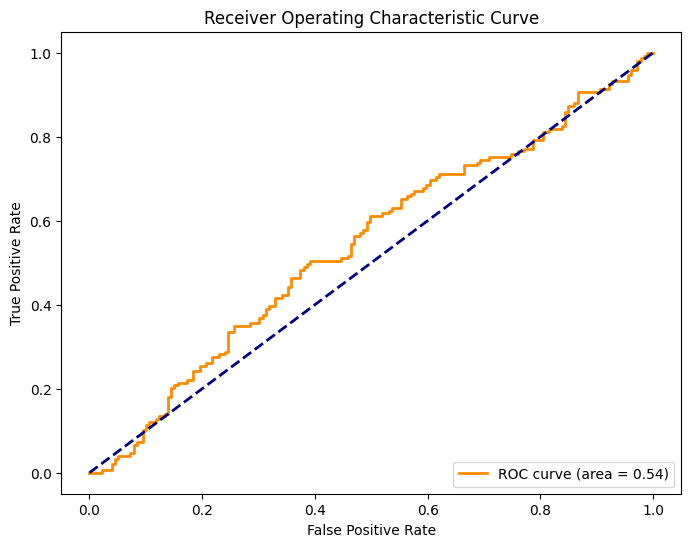

In [22]:
# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

# Confusion matrix
cm= confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)

# ROC- AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
df=df.drop(['국고채'], axis=1)
# X,y 지정
X,y= create_window_data(df, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

In [24]:
# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')


Accuracy : 0.5518


In [25]:
df_o=df

**국고채데이터는 빼는게 이득**

# Attention Feature Importance 반영

##1. 단순 피쳐 계수 고려

### 1) Feature Importance 계산 결과 음수 제외

cny_krw, usd_krw, gold, wti, jpy_krw, vix는 음의 계수를 보이므로 제외하고 모델링해보자

In [26]:
df.columns

Index(['kospi200', 'kosdaq', 'dow', 'nikkei', 'ssec', 'usd_krw', 'cny_krw',
       'jpy_krw', '콜금리', 'wti', 'brent', 'gold', 'vix', 'Target'],
      dtype='object')

feature_importance = pd.Series({
    'wti': 0.221272,
    'dow': 0.175300,
    'usd_krw': 0.081070,
    'gold': 0.057840,
    'vix': 0.024542,
    'jpy_krw': -0.048976,
    'brent': -0.076060,
    'nikkei': -0.109504,
    'kosdaq': -0.119270,
    'cny_krw': -0.132166,
    'ssec': -0.193056
})

음수 : jpy_krw, brent, nikkei, kosdaq, cny_krw, ssec

In [27]:
df_fi=df.drop(['jpy_krw', 'brent', 'nikkei', 'kosdaq', 'cny_krw', 'ssec'], axis=1)

# X,y 지정
X,y= create_window_data(df_fi, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.5183


In [35]:
0.6098-0.5954

0.014399999999999968

**예상과는 다르게 정확도가 0.03정도 더 감소하는 것을 확인할 수 있었다.**

###2) Feature Importance 계수 반영해 가중치 부여

In [28]:
# 피쳐 중요도 값을 딕셔너리 형태로 정의 (이미 제공된 값 사용)
feature_importance = {
    'dow': 0.175300,
    'ssec': -0.193056,
    'nikkei':  -0.109504,
    'brent': -0.076060,
    'kosdaq':  -0.119270,
    'cny_krw':  -0.132166,
    'usd_krw': 0.081070,
    'gold':  0.057840,
    'wti': 0.221272,
    'jpy_krw':  -0.048976,
    'vix': 0.024542,
}

# 피쳐 중요도 값을 배열 형태로 정의
feature_importance_arr = np.array(list(feature_importance.values()))

# 피쳐 가중치 적용
for feature, importance in feature_importance.items():
    if feature in df.columns:
        df[feature] *= importance

df.head()

,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,콜금리,wti,brent,gold,vix,Target
0,0.712342,-0.081925,0.172197,-0.097922,-0.105236,0.064514,-0.088175,-0.002162,NaN,0.131253,-0.046716,0.055334,0.001485,0.0
1,0.712094,-0.080454,0.172197,-0.097314,-0.105526,0.064514,-0.088815,-0.002542,NaN,0.129362,-0.046716,0.056453,0.001485,1.0
2,0.712508,-0.082291,0.171834,-0.097663,-0.106680,0.064670,-0.091982,-0.003541,NaN,0.132337,-0.047095,0.055205,0.001181,0.0
3,0.703218,-0.083422,0.169091,-0.096824,-0.106646,0.064377,-0.090094,-0.003340,NaN,0.131657,-0.046876,0.054345,0.001285,1.0
4,0.724992,-0.083860,0.167671,-0.097417,-0.102487,0.062956,-0.089102,-0.003112,NaN,0.129931,-0.046446,0.054436,0.001362,0.0


In [29]:
# X,y 지정
X,y= create_window_data(df, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.5427


**0.5518에서 0.5427로 정확도가 아주 약간 감소하였다.**

###3) Feature Importance 양수는 그대로 가중치 부여, 음수는 영향 삭제

feature_importance = pd.Series({
    'wti': 0.221272,
    'dow': 0.175300,
    'usd_krw': 0.081070,
    'gold': 0.057840,
    'vix': 0.024542,
    'jpy_krw': -0.048976,
    'brent': -0.076060,
    'nikkei': -0.109504,
    'kosdaq': -0.119270,
    'cny_krw': -0.132166,
    'ssec': -0.193056
})

음수 : jpy_krw, brent, nikkei, kosdaq, cny_krw, ssec

In [31]:
# 피쳐 중요도 값을 딕셔너리 형태로 정의 (이미 제공된 값 사용)
feature_importance = {
    'dow': 0.175300,
    'ssec': 0,
    'nikkei': 0,
    'brent': 0,
    'kosdaq': 0,
    'cny_krw': 0,
    'usd_krw': 0.081070,
    'gold': 0.057840,
    'wti': 0.221272,
    'jpy_krw': 0,
    'vix': 0.024542
}

# 피쳐 중요도 값을 배열 형태로 정의
feature_importance_arr = np.array(list(feature_importance.values()))

# 피쳐 가중치 적용
for feature, importance in feature_importance.items():
    if feature in df.columns:
        df[feature] *= importance

df.head()

,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,콜금리,wti,brent,gold,vix,Target
0,0.712342,-0.0,0.030186,-0.0,-0.0,0.005230,-0.0,-0.0,NaN,0.029043,-0.0,0.003200,0.000036,0.0
1,0.712094,-0.0,0.030186,-0.0,-0.0,0.005230,-0.0,-0.0,NaN,0.028624,-0.0,0.003265,0.000036,1.0
2,0.712508,-0.0,0.030123,-0.0,-0.0,0.005243,-0.0,-0.0,NaN,0.029282,-0.0,0.003193,0.000029,0.0
3,0.703218,-0.0,0.029642,-0.0,-0.0,0.005219,-0.0,-0.0,NaN,0.029132,-0.0,0.003143,0.000032,1.0
4,0.724992,-0.0,0.029393,-0.0,-0.0,0.005104,-0.0,-0.0,NaN,0.028750,-0.0,0.003149,0.000033,0.0


In [32]:
# X,y 지정
X,y= create_window_data(df, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.5183


**결론 : 예상과는 다르게 피쳐중요도를 고려한 결과 xgb의 성능이 감소하였다.**

**예상 가설**

1. 피쳐 간의 상호작용 : 어텐션 피쳐시각화는 개별 피쳐가 모델 예측에 기여하는 정도를 평가하므로, 피쳐간의 상호작용을 통해 중요한 역할을 할 경우 모델의 성능이 낮아질 수 있다.

2. 과적합 방지 : XGB는 자체적으로 피쳐 중요도를 학습과정에서 조정할 수 있으므로 인위적 조정이 모델의 학습을 방해할 수 있음

3. 데이터의 변동성

#2. SHAP 이용한 피쳐 중요도 계산 및 모델링

## 각 피쳐 중요도 시각화

In [ ]:
# X,y 지정
X,y= create_window_data(df_o, window_size=100)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')


Accuracy : 0.5518


In [ ]:
!pip install shap

In [ ]:
import shap
# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.reshape(X_test.shape[0], -1))

In [ ]:
shap_values

array([[-5.2615552e-04,  0.0000000e+00, -5.5153603e-03, ...,
         0.0000000e+00,  3.8482533e-03, -4.4287577e-02],
       [ 1.5962463e-04,  0.0000000e+00, -3.7635644e-03, ...,
         0.0000000e+00,  8.0560610e-02, -4.9673315e-02],
       [-1.1264523e-04,  0.0000000e+00, -5.7660965e-03, ...,
         0.0000000e+00,  3.8482533e-03,  1.7403792e-01],
       ...,
       [ 5.4583617e-04,  0.0000000e+00, -5.6263395e-03, ...,
         0.0000000e+00,  3.8482533e-03,  1.4143398e-01],
       [ 1.5962463e-04,  0.0000000e+00, -6.2140301e-03, ...,
         0.0000000e+00,  3.8482533e-03, -4.5483079e-02],
       [ 1.5962463e-04,  0.0000000e+00, -6.1682765e-03, ...,
         0.0000000e+00,  3.8482533e-03, -5.3567659e-02]], dtype=float32)

In [ ]:
shap_values.shape

(328, 1300)

In [ ]:
# 슬라이딩 윈도우 데이터 생성 함수
def create_window_data(data, window_size=100):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size), :-1].values)  # 마지막 열(Target)을 제외한 모든 열
        y.append(data.iloc[i + window_size, -1])  # 마지막 열(Target)
    return np.array(X), np.array(y)

In [ ]:
window_size=100
base_feature_names = df_o.columns[:-1]
feature_names = [f'{feature}_{i}' for i in range(window_size) for feature in base_feature_names]

In [ ]:
X_test.reshape(X_test.shape[0], -1).shape

(328, 1300)

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:962: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:962: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:962: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  pl.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLAB

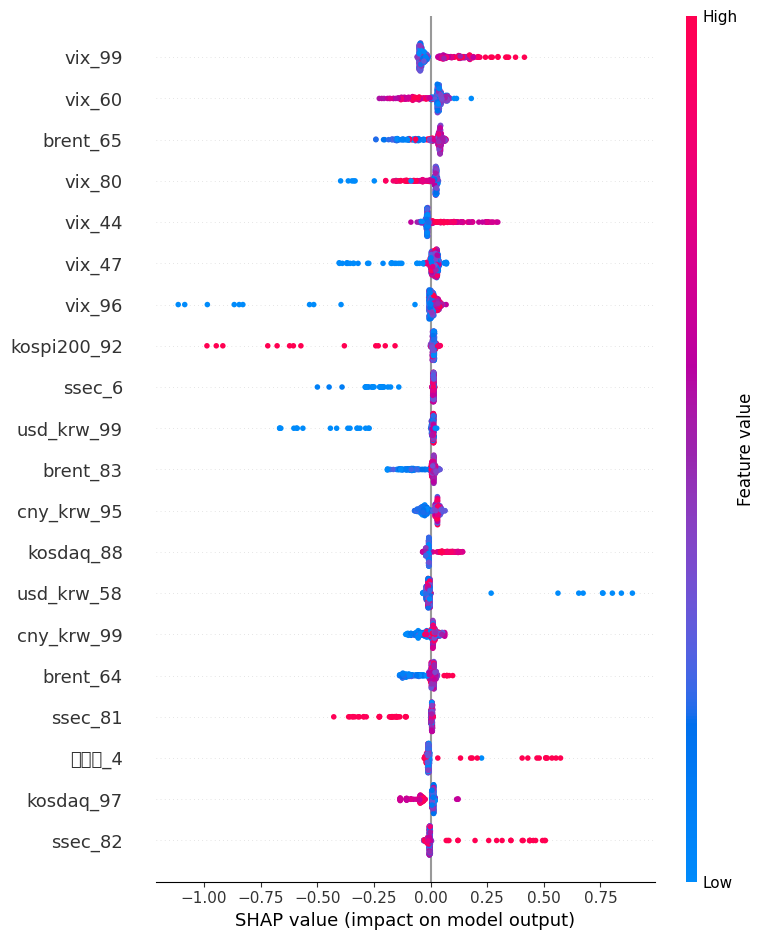

In [ ]:
# 시각화
# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test.reshape(X_test.shape[0], -1), feature_names=feature_names)

상위 20개의 피쳐가 표시되었다.

vix_99, vix_60, brent_65, vix_80, vix_44, vix_47, vix_96, kospi200_92, ssec_6, usd_krw_99, brent_83, cny_krw_95, kosdaq_88, usd_krw_58, cny_krw_99, brent_64, ssec_81, 000_4, kosdaq_97, ssec_82

shap 값은 특정 피처가 모델 예측에 미치는 영향을 나타낸다.

양수 값은 피처가 예측 확률을 증가시키는 방향으로, 음수 값은 감소시키는 방향으로 영향을 미친다.

점의 색상은 피처값의 크기를 나타내고, 빨간 색은 높은 값, 파란색은 낮은 값을 의미한다.

점이 넓게 퍼져있을 수록 해당 피처의 예측에 대한 영향이 다양하다는 것을 의미한다.

**해석 방법:**

**피처의 중요도:** Y축의 순서대로 피처가 모델 예측에 미치는 중요도가 높습니다. 따라서 상단에 있는 피처들이 모델 예측에 더 중요한 영향을 미친다고 볼 수 있습니다.


**SHAP 값의 크기와 방향:** X축에서 SHAP 값의 절대값이 클수록 해당 피처가 모델 예측에 더 큰 영향을 미칩니다. SHAP 값이 양수이면 해당 피처 값이 클수록 예측 확률이 증가함을 의미하고, 음수이면 예측 확률이 감소함을 의미합니다.

**피처 값의 효과:** 점의 색상을 통해 피처 값의 크기와 SHAP 값 간의 관계를 알 수 있습니다. 예를 들어, 빨간색(높은 값) 점이 오른쪽(양수 SHAP 값)에 많이 분포해 있다면, 해당 피처 값이 클수록 예측 확률이 증가한다는 것을 의미합니다.

## 피쳐 간 상호작용 확인

In [ ]:
# SHAP 상호작용 값 계산
shap_interaction_values = explainer.shap_interaction_values(X_test.reshape(X_test.shape[0], -1))

In [ ]:
shap_interaction_values

array([[[-6.9324422e-04,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00, -5.2249688e-03, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  7.3052798e-03,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00, -2.8732613e-02]],

       [[ 3.9802224e-04,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00, 

In [ ]:
shap_interaction_values.shape

(328, 1300, 1300)

테스트 세트에 328개의 샘플이 있고 각 샘플에 대해 1300개의 피처와 피처 간 상호작용이 계산되었음

In [ ]:
len(feature_names)

1300

In [ ]:
feature_names

['kospi200_0',
 'kosdaq_0',
 'dow_0',
 'nikkei_0',
 'ssec_0',
 'usd_krw_0',
 'cny_krw_0',
 'jpy_krw_0',
 '콜금리_0',
 'wti_0',
 'brent_0',
 'gold_0',
 'vix_0',
 'kospi200_1',
 'kosdaq_1',
 'dow_1',
 'nikkei_1',
 'ssec_1',
 'usd_krw_1',
 'cny_krw_1',
 'jpy_krw_1',
 '콜금리_1',
 'wti_1',
 'brent_1',
 'gold_1',
 'vix_1',
 'kospi200_2',
 'kosdaq_2',
 'dow_2',
 'nikkei_2',
 'ssec_2',
 'usd_krw_2',
 'cny_krw_2',
 'jpy_krw_2',
 '콜금리_2',
 'wti_2',
 'brent_2',
 'gold_2',
 'vix_2',
 'kospi200_3',
 'kosdaq_3',
 'dow_3',
 'nikkei_3',
 'ssec_3',
 'usd_krw_3',
 'cny_krw_3',
 'jpy_krw_3',
 '콜금리_3',
 'wti_3',
 'brent_3',
 'gold_3',
 'vix_3',
 'kospi200_4',
 'kosdaq_4',
 'dow_4',
 'nikkei_4',
 'ssec_4',
 'usd_krw_4',
 'cny_krw_4',
 'jpy_krw_4',
 '콜금리_4',
 'wti_4',
 'brent_4',
 'gold_4',
 'vix_4',
 'kospi200_5',
 'kosdaq_5',
 'dow_5',
 'nikkei_5',
 'ssec_5',
 'usd_krw_5',
 'cny_krw_5',
 'jpy_krw_5',
 '콜금리_5',
 'wti_5',
 'brent_5',
 'gold_5',
 'vix_5',
 'kospi200_6',
 'kosdaq_6',
 'dow_6',
 'nikkei_6',
 'ssec_

In [ ]:
mean_shap_interaction_values = np.mean(shap_interaction_values, axis=0)
print(mean_shap_interaction_values.shape)
mean_shap_interaction_values

(1300, 1300)


array([[-2.7054080e-05,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00, -7.6634307e-05, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  5.1463763e-03,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  2.5367044e-02]], dtype=float32)

In [ ]:
X_test.reshape(X_test.shape[0], -1).shape

(328, 1300)

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from cur

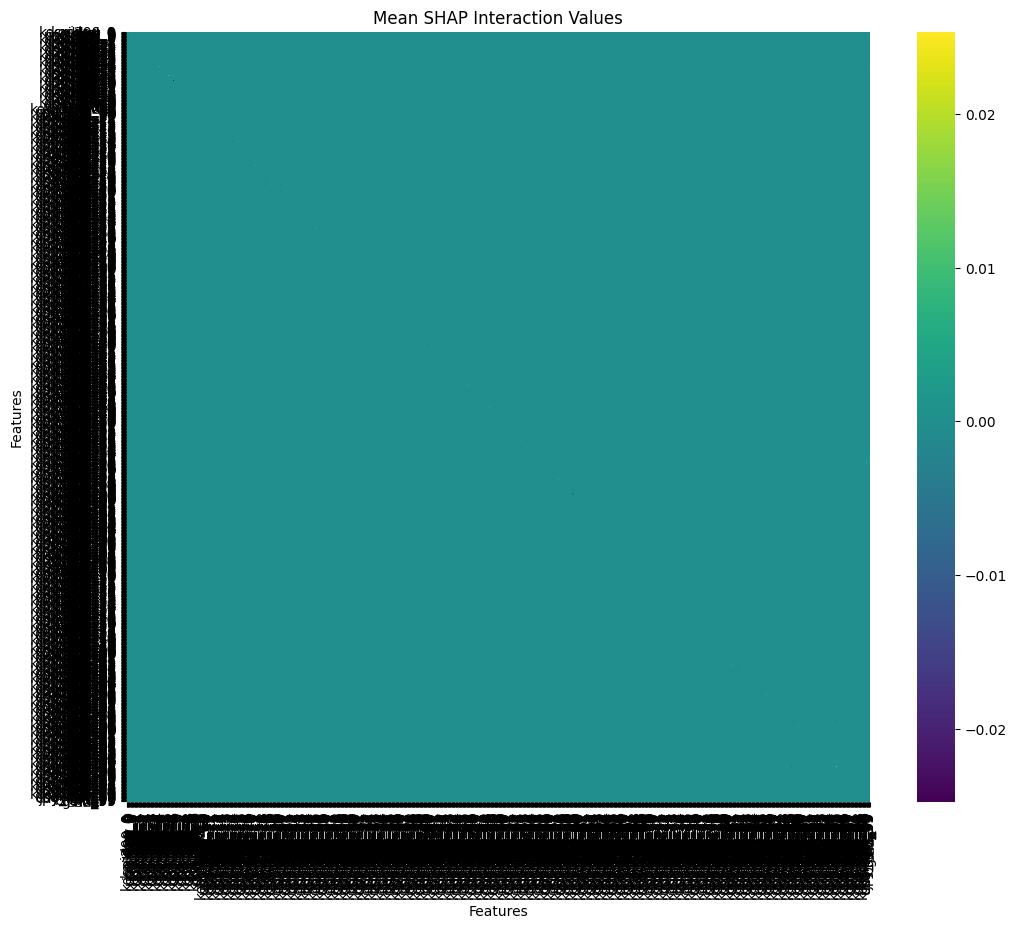

In [ ]:
# 히트맵을 사용한 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(mean_shap_interaction_values, xticklabels=feature_names, yticklabels=feature_names, cmap='viridis', annot=False)
plt.title('Mean SHAP Interaction Values')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from cur

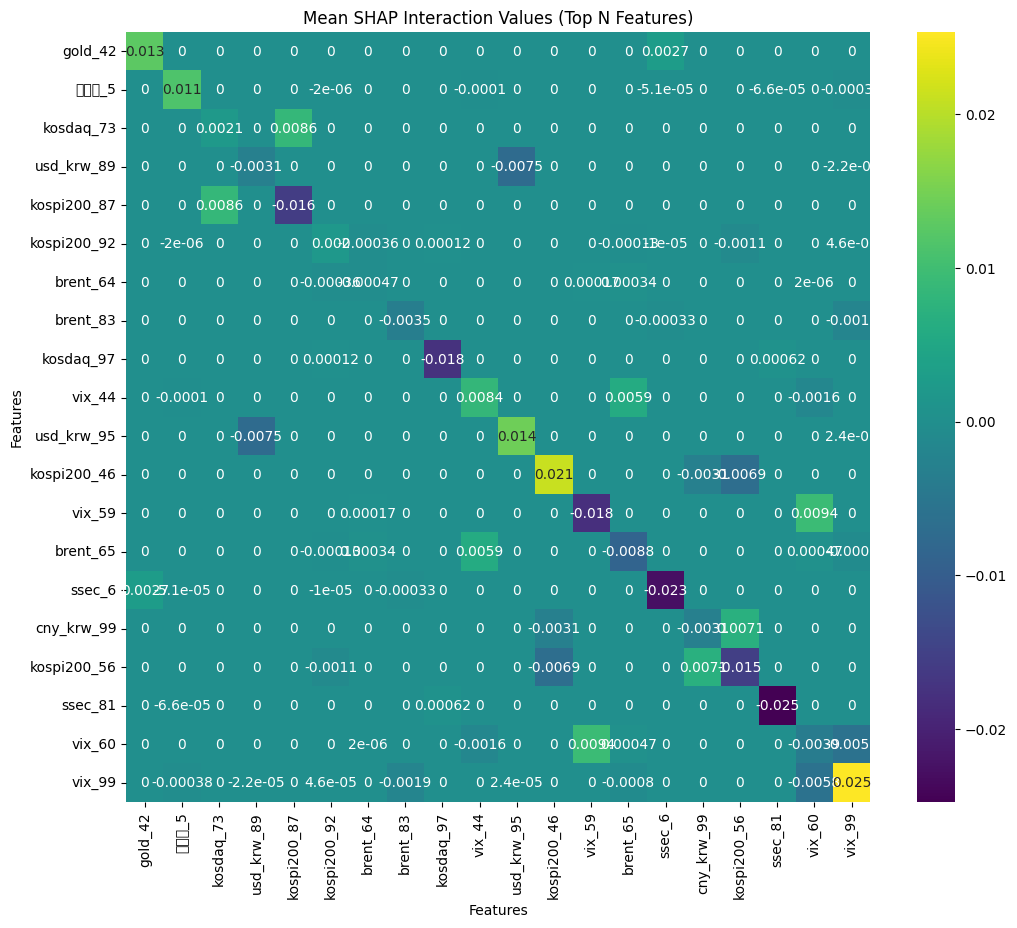

In [ ]:

# 상위 N개의 피처만 선택 (여기서는 상위 20개로 가정)
N = 20
important_features = np.argsort(np.abs(mean_shap_interaction_values).sum(axis=0))[-N:]
important_features_names = [feature_names[i] for i in important_features]

# 상위 N개의 피처에 대한 상호작용 값 선택
mean_shap_interaction_values_topN = mean_shap_interaction_values[important_features][:, important_features]

# 히트맵을 사용한 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(mean_shap_interaction_values_topN, xticklabels=important_features_names, yticklabels=important_features_names, cmap='viridis', annot=True)
plt.title('Mean SHAP Interaction Values (Top N Features)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

칼럼명의 의미
슬라이딩 윈도우 (사이즈=100)를 적용하여 피처가 1300개가 된 것이 맞습니다. vix_60과 같이 칼럼명에 붙은 숫자는 해당 피처가 슬라이딩 윈도우의 몇 번째 시간 단계에 해당하는지를 나타냅니다.

예를 들어, vix_60은 vix 피처의 60번째 시간 단계 값을 나타냅니다. 슬라이딩 윈도우를 적용하면 각 원래 피처가 윈도우 크기(여기서는 100)만큼 반복되므로, 총 피처 수는 원래 피처 수 * 윈도우 크기 = 13 * 100 = 1300이 됩니다.

히트맵의 결과를 보면 대부분의 값이 0에 가깝습니다. 이는 피처 간의 상호작용이 대부분 미미하다는 것을 나타낼 수 있습니다. 그러나 몇 가지 중요한 상호작용이 있을 수 있으며, 이러한 상호작용을 확인하려면 상위 N개의 상호작용을 분석하는 것이 좋습니다.

**피처 간의 연관성 평가**

상호작용 값이 0에 가까운 경우: 피처 간의 상호작용이 거의 없거나 미미함을 나타냅니다.
상호작용 값이 높은 경우: 해당 피처 쌍이 모델 예측에 중요한 상호작용을 가지고 있음을 나타냅니다.

히트맵을 통해 상호작용 값이 높은 피처 쌍을 식별하고, 이들 간의 상호작용을 더 자세히 분석할 수 있습니다.

##**SHAP 시각화 결론**

1) 피쳐 중요도 순으로 나열한 상위 20개의 피쳐는 다음과 같다.

[vix_99, vix_60, brent_65, vix_80, vix_44, vix_47, vix_96, kospi200_92, ssec_6, usd_krw_99, brent_83, cny_krw_95, kosdaq_88, usd_krw_58, cny_krw_99, brent_64, ssec_81, 000_4, kosdaq_97, ssec_82]

2) 피쳐 간 상호작용의 정도는 매우 미미하다.

#3. SHAP 상위 20개의 피쳐에 가중치 부여 후 모델 성능 개선 확인

In [ ]:
# 피처 중요도 상위 20개 피처
top_features = [
    'vix_99', 'vix_60', 'brent_65', 'vix_80', 'vix_44', 'vix_47', 'vix_96',
    'kospi200_92', 'ssec_6', 'usd_krw_99', 'brent_83', 'cny_krw_95',
    'kosdaq_88', 'usd_krw_58', 'cny_krw_99', 'brent_64', 'ssec_81', '000_4',
    'kosdaq_97', 'ssec_82'
]
# 상위 20개 피처에 가중치를 부여
def apply_feature_weights(X, feature_names, top_features, weight=2):
    for feature in top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            time_idx = idx // len(base_feature_names)
            feature_idx = idx % len(base_feature_names)
            X[:, time_idx, feature_idx] *= weight
    return X

In [ ]:
# 피처 가중치 적용

X_train_weighted = apply_feature_weights(X_train.copy(), feature_names, top_features)
X_test_weighted = apply_feature_weights(X_test.copy(), feature_names, top_features)


In [ ]:
# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_weighted.reshape(X_train_weighted.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_weighted.reshape(X_test_weighted.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.55182927


정확도 똑같음

**가중치 늘려보기**

In [ ]:
# 피처 중요도 상위 20개 피처
top_features = [
    'vix_99', 'vix_60', 'brent_65', 'vix_80', 'vix_44', 'vix_47', 'vix_96',
    'kospi200_92', 'ssec_6', 'usd_krw_99', 'brent_83', 'cny_krw_95',
    'kosdaq_88', 'usd_krw_58', 'cny_krw_99', 'brent_64', 'ssec_81', '000_4',
    'kosdaq_97', 'ssec_82'
]
# 상위 20개 피처에 가중치를 부여
def apply_feature_weights(X, feature_names, top_features, weight=10):
    for feature in top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            time_idx = idx // len(base_feature_names)
            feature_idx = idx % len(base_feature_names)
            X[:, time_idx, feature_idx] *= weight
    return X

In [ ]:
# 피처 가중치 적용

X_train_weighted = apply_feature_weights(X_train.copy(), feature_names, top_features)
X_test_weighted = apply_feature_weights(X_test.copy(), feature_names, top_features)


In [ ]:
# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_weighted.reshape(X_train_weighted.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_weighted.reshape(X_test_weighted.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.55182927


정확도에 차이없음...^^

In [ ]:
# 피처 중요도 상위 20개 피처
top_features = [
    'vix_99', 'vix_60', 'brent_65', 'vix_80', 'vix_44', 'vix_47', 'vix_96',
    'kospi200_92', 'ssec_6', 'usd_krw_99', 'brent_83', 'cny_krw_95',
    'kosdaq_88', 'usd_krw_58', 'cny_krw_99', 'brent_64', 'ssec_81', '000_4',
    'kosdaq_97', 'ssec_82'
]
# 상위 20개 피처에 가중치를 부여
def apply_feature_weights(X, feature_names, top_features, weight=100):
    for feature in top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            time_idx = idx // len(base_feature_names)
            feature_idx = idx % len(base_feature_names)
            X[:, time_idx, feature_idx] *= weight
    return X

In [ ]:
# 피처 가중치 적용

X_train_weighted = apply_feature_weights(X_train.copy(), feature_names, top_features)
X_test_weighted = apply_feature_weights(X_test.copy(), feature_names, top_features)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_weighted.reshape(X_train_weighted.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_weighted.reshape(X_test_weighted.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.55182927


**성능 개선에 별 효과가 없었따. ^^**

In [ ]:
# 가중치 적용 전후 확인
def print_feature_weights(X, feature_names, top_features):
    for feature in top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            time_idx = idx // len(base_feature_names)
            feature_idx = idx % len(base_feature_names)
            print(f'{feature}: {X[:, time_idx, feature_idx][:5]}')  # 첫 5개 값 출력

print("Before weighting:")
print_feature_weights(X_train, feature_names, top_features)

# 피처 가중치 적용
X_train_weighted = apply_feature_weights(X_train.copy(), feature_names, top_features, weight=100)
X_test_weighted = apply_feature_weights(X_test.copy(), feature_names, top_features, weight=100)

print("After weighting:")
print_feature_weights(X_train_weighted, feature_names, top_features)

Before weighting:
vix_99: [0.04310579 0.24299701 0.05711178 0.29004623 0.11884689]
vix_60: [0.09301061 0.2861028  0.07655698 0.28338319 0.12088659]
brent_65: [0.40239808 0.97688249 0.52201439 0.85371703 0.52901679]
vix_80: [0.15501768 0.26285015 0.05004079 0.15515366 0.09912973]
vix_44: [0.0465053  0.2402774  0.06472668 0.26285015 0.13176503]
vix_47: [0.06676639 0.23143867 0.05452815 0.29657329 0.10878434]
vix_96: [0.04691324 0.30527604 0.11123198 0.31683438 0.09844982]
kospi200_92: [0.35011612 0.6410501  0.41630723 0.65034008 0.96292303]
ssec_6: [0.34324266 0.62503897 0.15587405 0.65152956 0.87765086]
usd_krw_99: [0.20313583 0.50080833 0.14614181 0.38646103 0.15568785]
brent_83: [0.48959233 0.8882494  0.51865707 0.89352518 0.54206235]
cny_krw_95: [0.20745582 0.72960542 0.21883321 0.82619221 0.389252  ]
kosdaq_88: [0.51672603 0.69340616 0.57895987 0.7857516  0.92421436]
usd_krw_58: [0.32687521 0.62837127 0.18555775 0.54548487 0.22492237]
cny_krw_99: [0.19922537 0.71629145 0.25393367 0.

가중치 자체는 잘 적용되었음을 확인할 수 있었다.

>> 트리기반 모델이라 피쳐의 스케일이나 크기에 덜 민감해서일지도?

# SHAP 상위 피쳐만 이용해서 모델링

In [ ]:
# 상위 20개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-20:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4817


In [ ]:
# 상위 100개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-100:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5000


In [ ]:
# 상위 300개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-300:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.52439024


In [ ]:
# 상위 400개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-400:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5183


In [ ]:
# 상위 500개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-500:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5396


**상위 500개 선택했을 때의 성능이 가장 좋음**

In [ ]:
# 상위 550개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-550:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5183


In [ ]:
# 상위 600개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-600:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='logloss'
)
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.8f}')

Accuracy: 0.52439024


In [38]:
0.5518-0.5396

0.012199999999999989

##**의의**

- 1300개의 피쳐 중에서 300개만 사용해도 0.52의 성능을 낼 수 있다.

- 1300개의 피쳐 중에서 500개만 사용해도  0.5396의 성능을 낼 수 있다. (0.01떨어짐)


# 변화율

In [3]:
df=pd.read_csv("/content/drive/MyDrive/비타민 1학기 프로젝트 시계열 1조/변화율merged_data.csv")
df.head()

,날짜,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,wti,brent,gold,vix
0,2024-05-14,371.04,0.91%,0.32%,0.35%,-0.06%,-0.44%,-0.11%,-0.28%,1.32%,0.69%,-0.99%,8.37%
1,2024-05-13,370.98,-1.13%,-0.21%,-0.20%,-0.24%,-0.44%,-0.52%,-0.73%,-0.20%,0.69%,-0.36%,8.37%
2,2024-05-10,371.08,-0.69%,0.32%,0.49%,0.01%,0.10%,0.31%,0.15%,0.47%,0.36%,0.78%,-2.38%
3,2024-05-09,368.84,-0.27%,0.85%,-0.35%,0.86%,0.50%,0.17%,0.17%,1.20%,0.71%,-0.08%,-1.74%
4,2024-05-08,374.09,0.14%,0.44%,-1.63%,-0.61%,0.20%,0.40%,0.03%,-0.73%,-0.73%,-0.30%,-1.93%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   날짜        1739 non-null   object 
 1   kospi200  1739 non-null   float64
 2   kosdaq    1739 non-null   object 
 3   dow       1739 non-null   object 
 4   nikkei    1739 non-null   object 
 5   ssec      1739 non-null   object 
 6   usd_krw   1739 non-null   object 
 7   cny_krw   1739 non-null   object 
 8   jpy_krw   1739 non-null   object 
 9   wti       1739 non-null   object 
 10  brent     1739 non-null   object 
 11  gold      1739 non-null   object 
 12  vix       1739 non-null   object 
dtypes: float64(1), object(12)
memory usage: 176.7+ KB


In [5]:
# 슬라이딩 윈도우 데이터 생성 함수
def create_window_data(data, window_size=5):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size), :-1].values)
        y.append(data.iloc[i + window_size, -1])
    return np.array(X), np.array(y)

In [6]:
# 수익률 데이터에서 '%' 제거 후 숫자형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' and '%' in df[col].iloc[0]:
        df[col] = df[col].str.replace('%', '').astype(float) / 100

df.head()

,날짜,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,wti,brent,gold,vix
0,2024-05-14,371.04,0.0091,0.0032,0.0035,-0.0006,-0.0044,-0.0011,-0.0028,0.0132,0.0069,-0.0099,0.0837
1,2024-05-13,370.98,-0.0113,-0.0021,-0.0020,-0.0024,-0.0044,-0.0052,-0.0073,-0.0020,0.0069,-0.0036,0.0837
2,2024-05-10,371.08,-0.0069,0.0032,0.0049,0.0001,0.0010,0.0031,0.0015,0.0047,0.0036,0.0078,-0.0238
3,2024-05-09,368.84,-0.0027,0.0085,-0.0035,0.0086,0.0050,0.0017,0.0017,0.0120,0.0071,-0.0008,-0.0174
4,2024-05-08,374.09,0.0014,0.0044,-0.0163,-0.0061,0.0020,0.0040,0.0003,-0.0073,-0.0073,-0.0030,-0.0193


In [7]:
from sklearn.preprocessing import MinMaxScaler
# 데이터 로드 및 날짜 칼럼 변환
df['날짜'] = pd.to_datetime(df['날짜'])
# 타깃 변수 설정: 다음 날 주가 상승(1) / 하강(0)
df['Target'] = (df['kospi200'].shift(-1) > df['kospi200']).astype(int)

# 입력변수값 표준화
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(['날짜', 'Target'], axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns.drop(['날짜', 'Target']))

# 데이터와 타겟 컬럼 추가
df_scaled['Target'] = df['Target']

Accuracy : 0.6098
Confusion matrix:
[[136  47]
 [ 88  75]]


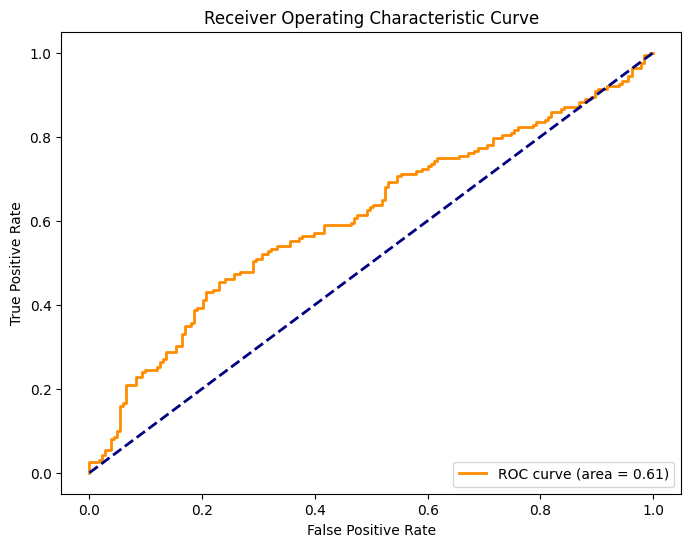

In [8]:
# 패키지 임포트
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

# X,y 지정
X,y= create_window_data(df_scaled, window_size=10)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

# Confusion matrix
cm= confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)

# ROC- AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
df=df_scaled

In [10]:
df_o=df_scaled

**종가와는 다르게 변화율에서는 window size가 10일때가 best**

# Attention Feature Importance 반영

feature_importance = pd.Series({
    'dow': 0.325531,
    'ssec': 0.238900,
    'nikkei': 0.195132,
    'brent': 0.076208,
    'kosdaq': 0.006516,
    'cny_krw': -0.000277,
    'usd_krw': -0.020725,
    'gold': -0.030892,
    'wti': -0.032822,
    'jpy_krw': -0.172221,
    'vix': -0.223214
})

음수 : cny_krw, usd_krw, gold, wti, jpy_krw, vix

###1) Feature Importance 계산 결과 음수 제외

In [11]:
df_fi=df.drop(['cny_krw', 'usd_krw', 'gold', 'wti', 'jpy_krw', 'vix'], axis=1)

# X,y 지정
X,y= create_window_data(df_fi, window_size=10)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.5838


성능이 0.02만큼 감소하였다.

##2) Feature Importance 계수 반영해 가중치 부여

feature_importance = pd.Series({
    'dow': 0.325531,
    'ssec': 0.238900,
    'nikkei': 0.195132,
    'brent': 0.076208,
    'kosdaq': 0.006516,
    'cny_krw': -0.000277,
    'usd_krw': -0.020725,
    'gold': -0.030892,
    'wti': -0.032822,
    'jpy_krw': -0.172221,
    'vix': -0.223214
})

In [12]:
# 피쳐 중요도 값을 딕셔너리 형태로 정의 (이미 제공된 값 사용)
feature_importance = {
    'dow': 0.325531,
    'ssec': 0.238900,
    'nikkei': 0.195132,
    'brent': 0.076208,
    'kosdaq': 0.006516,
    'cny_krw': -0.000277,
    'usd_krw': -0.020725,
    'gold': -0.030892,
    'wti': -0.032822,
    'jpy_krw': -0.172221,
    'vix': -0.223214
}

# 피쳐 중요도 값을 배열 형태로 정의
feature_importance_arr = np.array(list(feature_importance.values()))

# 피쳐 가중치 적용
for feature, importance in feature_importance.items():
    if feature in df.columns:
        df[feature] *= importance

df.head()

,kospi200,kosdaq,dow,nikkei,ssec,usd_krw,cny_krw,jpy_krw,wti,brent,gold,vix,Target
0,0.712342,0.003933,0.177501,0.088860,0.136260,-0.011277,-0.000152,-0.084451,-0.013684,0.042097,-0.011295,-0.054072,0
1,0.712094,0.003297,0.170401,0.081259,0.133058,-0.011277,-0.000128,-0.075113,-0.013083,0.042097,-0.013074,-0.054072,1
2,0.712508,0.003434,0.177501,0.090794,0.137505,-0.013576,-0.000177,-0.093373,-0.013348,0.041544,-0.016293,-0.037116,0
3,0.703218,0.003565,0.184602,0.079186,0.152626,-0.015278,-0.000169,-0.093788,-0.013637,0.042131,-0.013865,-0.038125,1
4,0.724992,0.003693,0.179109,0.061497,0.126476,-0.014001,-0.000183,-0.090883,-0.012873,0.039715,-0.013243,-0.037825,0


In [13]:
# X,y 지정
X,y= create_window_data(df, window_size=10)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.6098


성능이 동일하게 관찰되었다.

##3) Feature Importance 양수는 그대로 가중치 부여, 음수는 영향 삭제

In [14]:
# 피쳐 중요도 값을 딕셔너리 형태로 정의 (이미 제공된 값 사용)
feature_importance = {
    'dow': 0.325531,
    'ssec': 0.238900,
    'nikkei': 0.195132,
    'brent': 0.076208,
    'kosdaq': 0.006516,
    'cny_krw': 0,
    'usd_krw': 0,
    'gold': 0,
    'wti': 0,
    'jpy_krw': 0,
    'vix': 0
}

# 피쳐 중요도 값을 배열 형태로 정의
feature_importance_arr = np.array(list(feature_importance.values()))

# 피쳐 가중치 적용
for feature, importance in feature_importance.items():
    if feature in df.columns:
        df[feature] *= importance

# X,y 지정
X,y= create_window_data(df, window_size=10)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.5838


1)과 동일한 결과가 출력되었다.

# SHAP 이용한 피쳐 중요도 계산 및 모델링

##각 피쳐 중요도 시각화

In [15]:
df=pd.read_csv("/content/drive/MyDrive/비타민 1학기 프로젝트 시계열 1조/변화율merged_data.csv")
# 수익률 데이터에서 '%' 제거 후 숫자형으로 변환
for col in df.columns:
    if df[col].dtype == 'object' and '%' in df[col].iloc[0]:
        df[col] = df[col].str.replace('%', '').astype(float) / 100

from sklearn.preprocessing import MinMaxScaler
# 데이터 로드 및 날짜 칼럼 변환
df['날짜'] = pd.to_datetime(df['날짜'])
# 타깃 변수 설정: 다음 날 주가 상승(1) / 하강(0)
df['Target'] = (df['kospi200'].shift(-1) > df['kospi200']).astype(int)

# 입력변수값 표준화
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(['날짜', 'Target'], axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=df.columns.drop(['날짜', 'Target']))

# 데이터와 타겟 컬럼 추가
df_scaled['Target'] = df['Target']

df_shap=df_scaled

In [16]:
# X,y 지정
X,y= create_window_data(df_shap, window_size=10)

# 데이터 분할
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=156)

# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))
y_proba= model.predict_proba(X_test.reshape(X_test.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.6098


In [17]:
!pip install shap

In [18]:
import shap
# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.reshape(X_test.shape[0], -1))

In [19]:
shap_values.shape

(346, 120)

In [20]:
window_size=10
base_feature_names = df_shap.columns[:-1]
feature_names = [f'{feature}_{i}' for i in range(window_size) for feature in base_feature_names]

In [21]:
X_test.reshape(X_test.shape[0], -1).shape

(346, 120)

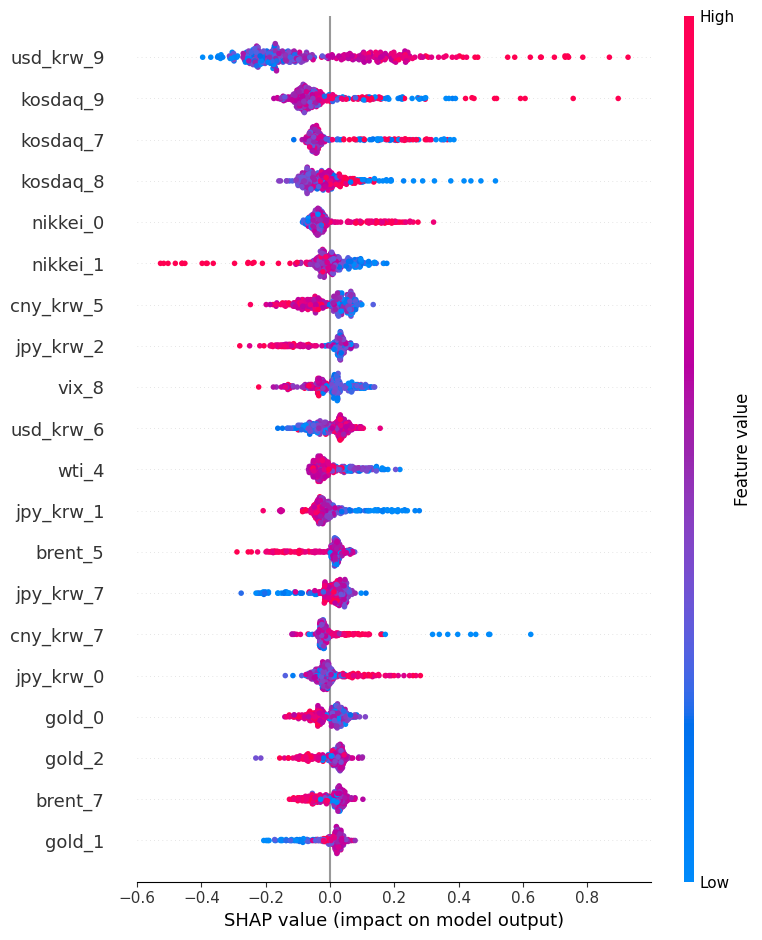

In [22]:
# 시각화
# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test.reshape(X_test.shape[0], -1), feature_names=feature_names)

상위 20개가 표시되었다.

usd_krw_9, kosdaq_9, kosdaq_7, kosdaq_8,nikkei_0, nikkei_1, cny_krw_5, jpy_krw2, vix_8, usd_krw_6, wti_4, jpy_krw_1, brent_5, jpy_krw_7, cny_krw_7, jpy_krw_0, gold_0, gold_2, brent_7, gold_1

shap 값은 특정 피처가 모델 예측에 미치는 영향을 나타낸다.

양수 값은 피처가 예측 확률을 증가시키는 방향으로, 음수 값은 감소시키는 방향으로 영향을 미친다.

점의 색상은 피처값의 크기를 나타내고, 빨간 색은 높은 값, 파란색은 낮은 값을 의미한다.

점이 넓게 퍼져있을 수록 해당 피처의 예측에 대한 영향이 다양하다는 것을 의미한다.



## 피쳐 간 상호작용 확인

In [23]:
# SHAP 상호작용 값 계산
shap_interaction_values = explainer.shap_interaction_values(X_test.reshape(X_test.shape[0], -1))

In [24]:
shap_interaction_values.shape

(346, 120, 120)

In [25]:
len(feature_names)

120

In [26]:
mean_shap_interaction_values = np.mean(shap_interaction_values, axis=0)
print(mean_shap_interaction_values.shape)
mean_shap_interaction_values

(120, 120)


array([[ 1.1146429e-03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  3.5947720e-03,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  2.6928249e-04, ...,
         0.0000000e+00,  1.7026181e-05,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.4377149e-03,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.7026274e-05, ...,
         0.0000000e+00, -1.7554549e-03,  7.0818853e-05],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  7.0818824e-05, -7.9159217e-04]], dtype=float32)

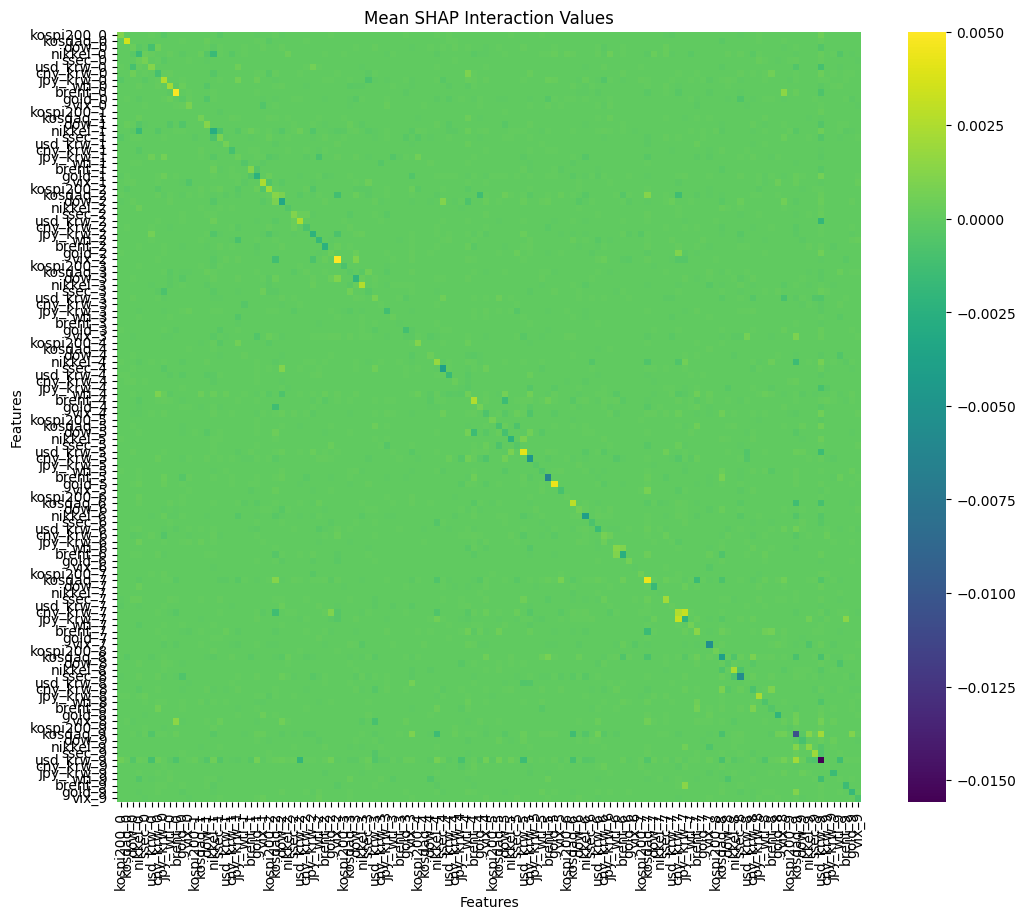

In [27]:
# 히트맵을 사용한 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(mean_shap_interaction_values, xticklabels=feature_names, yticklabels=feature_names, cmap='viridis', annot=False)
plt.title('Mean SHAP Interaction Values')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

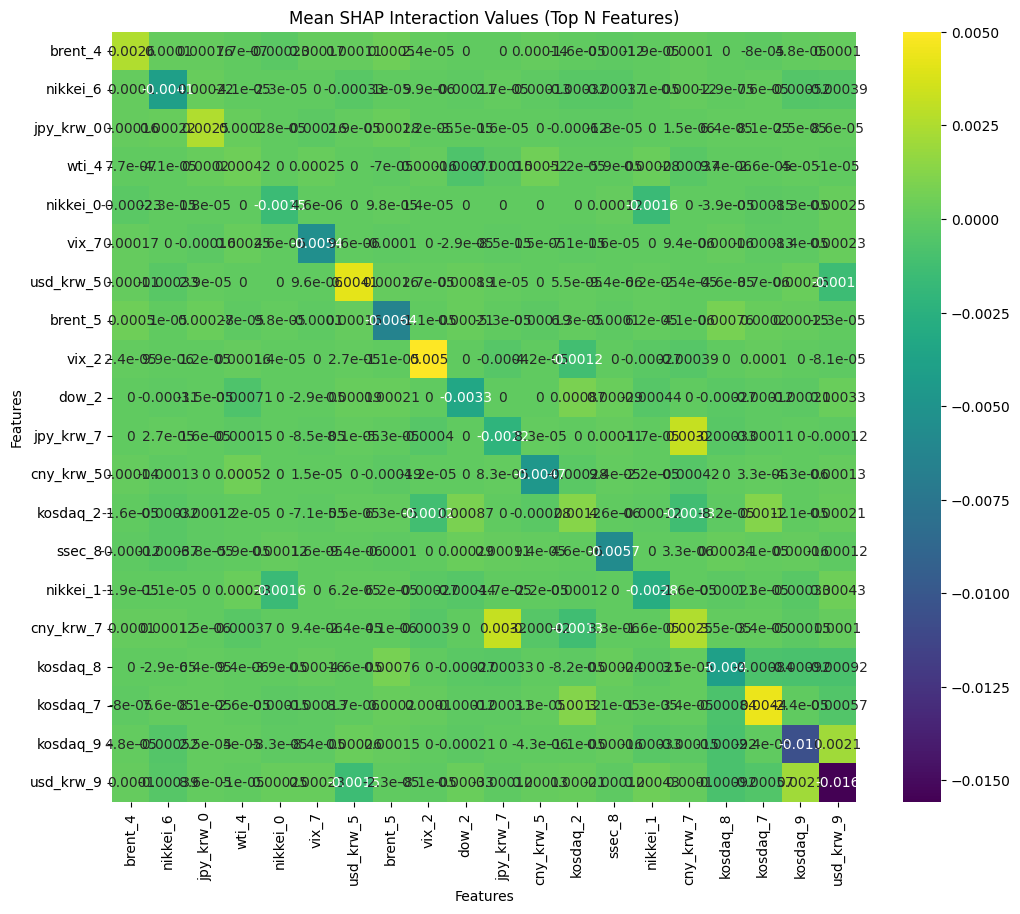

In [28]:

# 상위 N개의 피처만 선택 (여기서는 상위 20개로 가정)
N = 20
important_features = np.argsort(np.abs(mean_shap_interaction_values).sum(axis=0))[-N:]
important_features_names = [feature_names[i] for i in important_features]

# 상위 N개의 피처에 대한 상호작용 값 선택
mean_shap_interaction_values_topN = mean_shap_interaction_values[important_features][:, important_features]

# 히트맵을 사용한 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(mean_shap_interaction_values_topN, xticklabels=important_features_names, yticklabels=important_features_names, cmap='viridis', annot=True)
plt.title('Mean SHAP Interaction Values (Top N Features)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

##SHAP 상위 20개의 피쳐에 가중치 부여 후 모델 성능 개선 확인

In [29]:
# 피처 중요도 상위 20개 피처
top_features = [
    'usd_krw_9', 'kosdaq_9', 'kosdaq_7', 'kosdaq_8',
    'nikkei_0', 'nikkei_1', 'cny_krw_5', 'jpy_krw2', 'vix_8',
    'usd_krw_6', 'wti_4', 'jpy_krw_1', 'brent_5', 'jpy_krw_7',
    'cny_krw_7', 'jpy_krw_0', 'gold_0', 'gold_2', 'brent_7', 'gold_1'
]
# 상위 20개 피처에 가중치를 부여
def apply_feature_weights(X, feature_names, top_features, weight=2):
    for feature in top_features:
        if feature in feature_names:
            idx = feature_names.index(feature)
            time_idx = idx // len(base_feature_names)
            feature_idx = idx % len(base_feature_names)
            X[:, time_idx, feature_idx] *= weight
    return X

In [30]:
# 피처 가중치 적용

X_train_weighted = apply_feature_weights(X_train.copy(), feature_names, top_features)
X_test_weighted = apply_feature_weights(X_test.copy(), feature_names, top_features)


In [31]:
# 모델 생성 및 훈련
model= xgb.XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_weighted.reshape(X_train_weighted.shape[0],-1), y_train)

# 예측
y_pred = model.predict(X_test_weighted.reshape(X_test_weighted.shape[0],-1))
y_proba= model.predict_proba(X_test_weighted.reshape(X_test_weighted.shape[0],-1))[:,1]

# 평가
# 정확도 계산
accuracy= accuracy_score(y_test, y_pred)
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.6098


**정확도에 차이 X**

## SHAP 상위 피쳐만 이용해 모델링

In [32]:
# 상위 20개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-20:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5694


이번에는 어텐션이 더 효과가 있었다.

In [33]:
# 상위 10개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-10:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5954


In [34]:
# 상위 5개 피처 선택
shap_sum = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(shap_sum)[-5:]
top_features = [feature_names[i] for i in top_indices]

# 선택된 피처 인덱스
selected_feature_indices = [feature_names.index(feature) for feature in top_features]

def select_top_features(X, selected_indices):
    # 3차원 배열을 2차원 배열로 재구성한 후, 필요한 피처 선택
    X_reshaped = X.reshape(X.shape[0], -1)
    X_selected = X_reshaped[:, selected_indices]
    return X_selected

# 상위 20개 피처 선택 적용
X_train_selected = select_top_features(X_train, selected_feature_indices)
X_test_selected = select_top_features(X_test, selected_feature_indices)

# 모델 생성 및 훈련
model = xgb.XGBClassifier(
    learning_rate=0.05, max_depth=5, n_estimators=100,objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_selected.reshape(X_train_selected.shape[0], -1), y_train)

# 예측
y_pred = model.predict(X_test_selected.reshape(X_test_selected.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5925
